In [1]:
import torch 
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import matplotlib.pylab as plt
import numpy as np

In [2]:
IMAGE_SIZE=16
composed = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)), transforms.ToTensor()])

In [3]:
# lolad the data
# if FloatProgress error  use -- >>  !pip install ipywidgets --upgrade
train_dataset = dsets.MNIST(root='./data', train=True, download=True, transform=composed)
validation_dataset = dsets.MNIST(root='./data', train=False, download=True, transform=composed)

In [129]:
# check the labels
np.unique(train_dataset.train_labels.numpy())

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [4]:
def show_img(img):
    plt.imshow(img[0].numpy().reshape(IMAGE_SIZE, IMAGE_SIZE), cmap='gray')
    plt.title('y='+str(img[1]))
    plt.show()

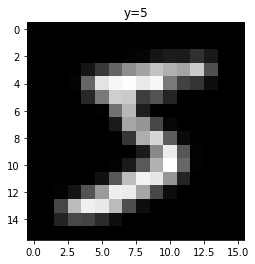

In [5]:
show_img(train_dataset[0])

In [6]:
train_dataset[0][1]

5

In [8]:
def conv_output_shape(h_w, kernel_size=1, stride=1, pad=0, dilation=1):
    #by Duane Nielsen
    from math import floor
    if type(kernel_size) is not tuple:
        kernel_size = (kernel_size, kernel_size)
    h = floor( ((h_w[0] + (2 * pad) - ( dilation * (kernel_size[0] - 1) ) - 1 )/ stride) + 1)
    w = floor( ((h_w[1] + (2 * pad) - ( dilation * (kernel_size[1] - 1) ) - 1 )/ stride) + 1)
    return h, w

In [9]:
out1 = conv_output_shape((IMAGE_SIZE, IMAGE_SIZE), kernel_size=5, stride=1, pad=2, dilation=1)
out2 = conv_output_shape(out1, kernel_size=2, stride=2, pad=0, dilation=1)
out3 = conv_output_shape(out2, kernel_size=5, stride=1, pad=2, dilation=1)
out4 = conv_output_shape(out3, kernel_size=2, stride=2, pad=0, dilation=1)

print("\n",out1,"\n",out2,"\n", out3,"\n", out4)


 (16, 16) 
 (8, 8) 
 (8, 8) 
 (4, 4)


### Build the CNN

In [96]:
class CNN(nn.Module):
    def __init__(self, out_1, out_2):
        super(CNN,self).__init__()
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=out_1, kernel_size=5, padding=2)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        self.cnn2 = nn.Conv2d(in_channels=out_1, out_channels=out_2, kernel_size=5, padding=2)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(out_2*4*4, 10)
    def forward(self,x):
        x = self.cnn1(x)
        x = self.maxpool1(x)
        x = torch.relu(x)
        x = self.cnn2(x)
        x = self.maxpool2(x)
        x = torch.relu(x)     
        x  = x.view(x.size(0), -1)  # reshape tensor to one column format (flat)
        x = self.fc1(x)
        return x

### Build CNN with batch normalization

In [97]:
class CNN_bn(nn.Module):
    def __init__(self, out_1, out_2):
        super(CNN_bn,self).__init__()
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=out_1, kernel_size=5, padding=2)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        self.cnn_bn1 = nn.BatchNorm2d(out_1)
        self.cnn2 = nn.Conv2d(in_channels=out_1, out_channels=out_2, kernel_size=5, padding=2)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        self.cnn_bn2 = nn.BatchNorm2d(out_2)
        self.fc1 = nn.Linear(out_2*4*4, 10)
        self.bn_fc1 = nn.BatchNorm1d(10)
    def forward(self,x):
        x = self.cnn1(x)
        x = self.cnn_bn1(x)
        x = self.maxpool1(x)
        x = torch.relu(x)
        x = self.cnn2(x)
        x = self.cnn_bn2(x)
        x = self.maxpool2(x)
        x = torch.relu(x)
        x  = x.view(x.size(0), -1)  # reshape tensor to one column format (flat)
        x = self.fc1(x)
        x = self.bn_fc1(x)
        return x

In [98]:
model = CNN(out_1=16, out_2=32)
model_bn = CNN_bn(out_1=16, out_2=32)

In [99]:
criterion = nn.CrossEntropyLoss()
learning_rate = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
optimizer_bn = torch.optim.SGD(model_bn.parameters(), lr = learning_rate)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=100)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=5000)

#### Try to go thru the CNN model with one and two pictures

In [58]:
next(iter(train_loader))[0].shape  # all batch

torch.Size([100, 1, 16, 16])

In [53]:
next(iter(train_loader))[0][:1].shape  # only one sample

torch.Size([1, 1, 16, 16])

In [57]:
model.eval()  # without eval() there is error (BatchNorm2d layer works only for more then one sample, see below)
model(next(iter(train_loader))[0][:1])

tensor([[-0.1350,  0.1788,  0.1792,  0.0069, -0.0500,  0.1557,  0.1254, -0.2438,
         -0.1980,  0.0869]], grad_fn=<NativeBatchNormBackward>)

In [56]:
model.train()
model(next(iter(train_loader))[0][:2])

tensor([[-0.9699,  0.9999, -0.9999, -0.9996,  1.0000,  0.9998, -0.9995, -0.9981,
         -0.9993,  1.0000],
        [ 0.9699, -0.9999,  0.9999,  0.9996, -1.0000, -0.9998,  0.9995,  0.9981,
          0.9993, -1.0000]], grad_fn=<NativeBatchNormBackward>)

Train the Model (funciton)

In [100]:
def train_model(model, optimizer, train_loader, validation_loader, n_epochs):
    N_test = len(validation_dataset)
    accuracy_list = []
    loss_list = []
    
    for e in range(n_epochs):
        
        for x, y in train_loader:
            model.train()
            optimizer.zero_grad()
            z = model(x)
            loss = criterion(z, y)
            loss.backward()
            optimizer.step()
            loss_list.append(loss.data)
            
        correct=0
        for x_test, y_test in validation_loader:
            with torch.no_grad():     # we use torch.no_grad() to speed up computation and low memory usage
                model.eval()  # eval has effect only on some layers in the NN (Dropout, Batchnorm)
                z = model(x_test)
                _, y_hat = torch.max(z.data,1)
                correct += (y_hat==y_test).sum().item()
        accuracy = correct/N_test
        accuracy_list.append(accuracy)
        
    return accuracy_list, loss_list   

In [101]:
accuracy_list, loss_list = train_model(model=model, optimizer=optimizer, train_loader=train_loader, 
                                       validation_loader=validation_loader, n_epochs=10)

In [102]:
accuracy_list_bn, loss_list_bn = train_model(model=model_bn, optimizer=optimizer_bn, train_loader=train_loader, 
                                             validation_loader=validation_loader, n_epochs=10)

### Plot accuracy and loss for CNN model with and without batch normalization

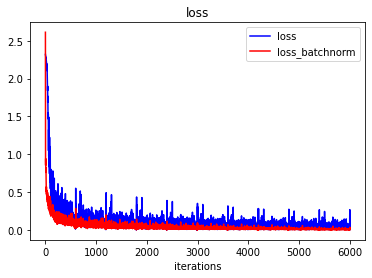

In [103]:
plt.plot(loss_list, 'b', label='loss')
plt.plot(loss_list_bn, 'r', label='loss_batchnorm')
plt.xlabel('iterations')
plt.title('loss')
plt.legend()
plt.show()

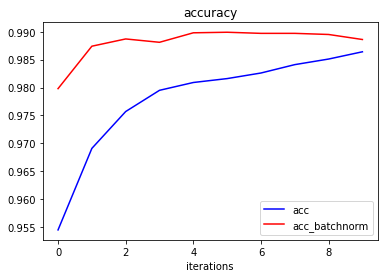

In [104]:
plt.plot(accuracy_list, 'b', label='acc')
plt.plot(accuracy_list_bn, 'r', label='acc_batchnorm')
plt.xlabel('iterations')
plt.title('accuracy')
plt.legend()
plt.show()

Plot the same data on the one plot

In [ ]:
# Plot Cost/Loss and Accuracy of the model
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.plot(accuracy_list, color=color)
ax1.set_xlabel('epoch', color=color)
ax1.set_ylabel('Acc', color=color)
ax1.tick_params(axis='y', color=color)
    
ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('accuracy', color=color) 
ax2.set_xlabel('epoch', color=color)
ax2.plot( accuracy_list, color=color)
ax2.tick_params(axis='y', color=color)

plt.title("Cost and Accuracy\nof Batch Norm model\n")
fig.tight_layout()